**Install Required Libraries**

In [16]:
!pip install PyMuPDF
!pip install nltk
!pip install matplotlib seaborn


**Import Libraries**

In [18]:
import os
import re
import fitz  # PyMuPDF for PDF text extraction
import torch
import numpy as np
import pandas as pd
import nltk
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# NLTK resources for text cleaning
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Text Cleaning Function – Normalization, Stopword Removal, Lemmatization**



In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'\S+@\S+', '', text)  # Remove emails
    text = re.sub(r'\d{10}|\+?\d[\d -]{8,12}\d', '', text)  # Remove phone numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)


**Load Foundation Model (BERT from HuggingFace)**

In [6]:
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

**upload Resume Dataset CSV and Process Each Resume**


In [15]:
# Upload and load your CSV file
uploaded = files.upload()
df = pd.read_csv("resume_dataset_large.csv")

# Preprocess and embed each resume
df['cleaned_text'] = df['resume_text'].apply(preprocess_text)
df['embedding'] = df['cleaned_text'].apply(get_bert_embedding)

# View first few rows
df.head()

Saving resume_dataset_large.csv to resume_dataset_large (1).csv


,resume_text,job_category,cleaned_text,embedding
0,"Python, pandas, numpy, data visualization, mac...",Data Science,python panda numpy data visualization machine ...,"[-0.20325175, -0.22759521, 0.2535777, 0.046082..."
1,"Designed scalable backend systems, implemented...",Software Development,designed scalable backend system implemented a...,"[-0.1398428, -0.34146836, 0.21370716, 0.193847..."
2,"Managed recruitment processes, handled employe...",Human Resources,managed recruitment process handled employee o...,"[0.02306105, 0.23481545, 0.03672036, 0.1229101..."
3,"Created marketing funnels, email automation wo...",Marketing,created marketing funnel email automation work...,"[-0.17968519, 0.054422155, 0.044121355, -0.051..."
4,PMP certified professional with experience in ...,Project Management,pmp certified professional experience risk man...,"[-0.010442588, 0.19198556, -0.013224305, 0.051..."


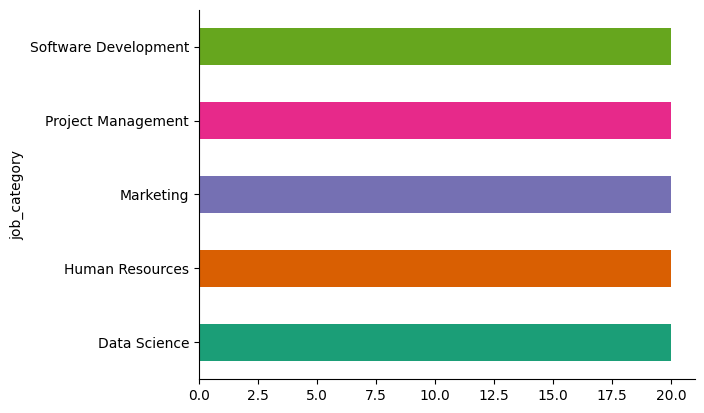

In [14]:
# @title job_category

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('job_category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

**Prepare Features and Labels for Training**

In [9]:
X = np.stack(df['embedding'].values)
y = df['job_category'].values

**Train Logistic Regression Classifier**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(" Classification Report:\n")
print(classification_report(y_test, y_pred))
print(" Accuracy Score:", accuracy_score(y_test, y_pred))


 Classification Report:

                      precision    recall  f1-score   support

        Data Science       1.00      1.00      1.00         4
     Human Resources       1.00      1.00      1.00         4
           Marketing       1.00      1.00      1.00         4
  Project Management       1.00      1.00      1.00         4
Software Development       1.00      1.00      1.00         4

            accuracy                           1.00        20
           macro avg       1.00      1.00      1.00        20
        weighted avg       1.00      1.00      1.00        20

 Accuracy Score: 1.0


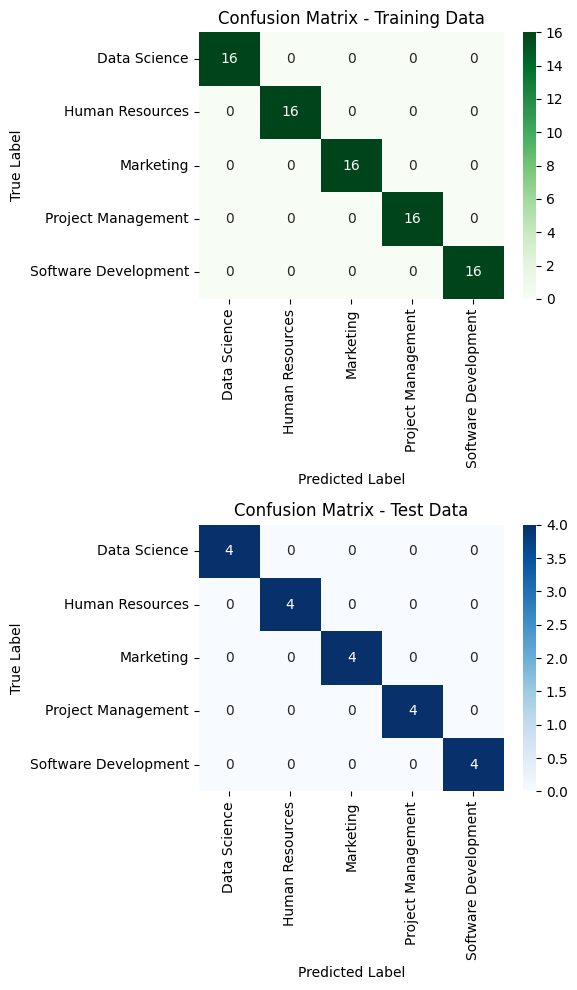

In [19]:
# Predict on training set
y_train_pred = clf.predict(X_train)

# Confusion Matrices
train_cm = confusion_matrix(y_train, y_train_pred, labels=clf.classes_)
test_cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

# Plot Confusion Matrices
fig, axes = plt.subplots(2, 1, figsize=(6, 10))

# Training Confusion Matrix
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Greens", ax=axes[0],
            xticklabels=clf.classes_, yticklabels=clf.classes_)
axes[0].set_title("Confusion Matrix - Training Data")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Test Confusion Matrix
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", ax=axes[1],
            xticklabels=clf.classes_, yticklabels=clf.classes_)
axes[1].set_title("Confusion Matrix - Test Data")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()


**single Resume Classification**

In [11]:
uploaded = files.upload()

def extract_text_from_pdf(path):
    doc = fitz.open(path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

pdf_path = next(iter(uploaded))
resume_text = extract_text_from_pdf(pdf_path)
cleaned_text = preprocess_text(resume_text)
resume_embedding = get_bert_embedding(cleaned_text).reshape(1, -1)
predicted_category = clf.predict(resume_embedding)[0]

print("Predicted Job Category:", predicted_category)

Saving resume_software_dev.pdf to resume_software_dev.pdf
Predicted Job Category: Software Development


**Batch Resume Classification from Folder**

In [12]:
# Upload multiple PDFs into a folder
folder_path = "resume_folder"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

uploaded_files = files.upload()
for filename in uploaded_files.keys():
    if filename.endswith(".pdf"):
        os.rename(filename, os.path.join(folder_path, filename))

Saving resume_marketing.pdf to resume_marketing.pdf
Saving resume_software_dev.pdf to resume_software_dev (1).pdf
Saving resume_data_science.pdf to resume_data_science.pdf
Saving resume_hr.pdf to resume_hr.pdf


**Classify All PDFs in Folder and Generate Report**

In [13]:
def classify_resumes_in_folder(folder_path):
    results = []
    for file in os.listdir(folder_path):
        if file.endswith(".pdf"):
            path = os.path.join(folder_path, file)
            try:
                text = extract_text_from_pdf(path)
                cleaned = preprocess_text(text)
                embedding = get_bert_embedding(cleaned).reshape(1, -1)
                category = clf.predict(embedding)[0]
                results.append({"Resume File": file, "Predicted Category": category})
            except Exception as e:
                results.append({"Resume File": file, "Predicted Category": f"Error: {str(e)}"})
    return pd.DataFrame(results)

# Generate and download report
df_report = classify_resumes_in_folder(folder_path)
df_report.to_csv("resume_classification_report.csv", index=False)
print("Resume Classification Report:\n")
print(df_report)

files.download("resume_classification_report.csv")


Resume Classification Report:

                   Resume File    Predicted Category
0      resume_data_science.pdf          Data Science
1                resume_hr.pdf       Human Resources
2         resume_marketing.pdf             Marketing
3  resume_software_dev (1).pdf  Software Development


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

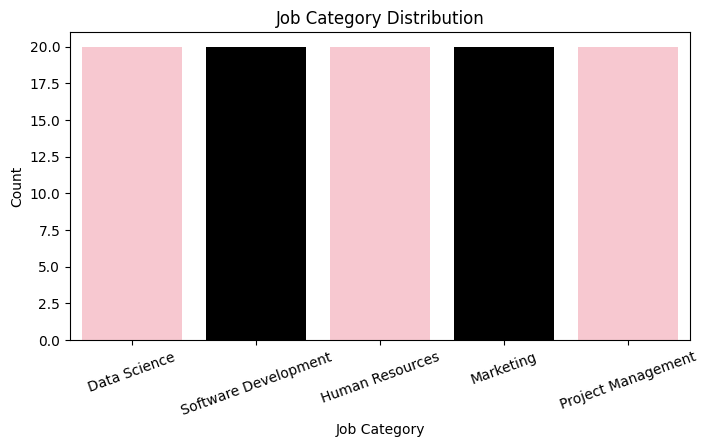

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.countplot(x=df['job_category'], palette=["pink", "black"])
plt.title("Job Category Distribution")
plt.xlabel("Job Category")
plt.ylabel("Count")
plt.xticks(rotation=20)
plt.show()
